In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import bigquery, storage
import warnings
import os

warnings.filterwarnings("ignore")

### Designing the Data Warehouse Schema
A recommended approach is to break down final_data into dimension and fact tables. For example:

- Fact Table: fact_listings

Contains keys referencing dimension tables.
Contains metrics such as price_y, availability_365, number_of_reviews, revenue (derived).

- Dimension Tables:

dim_host: Information about hosts (host_id, host_name, host_since, host_location).
dim_geography: Information about location (neighbourhood_cleansed, city, state, country, latitude, longitude).
dim_property: Information about listings (property_type, room_type, accommodates, bedrooms, beds).
dim_date: A date dimension for first_review, last_review.
Note: If you have all data in one table, you can create views or separate tables to follow a star schema.

Split the final_data into dimension and fact tables locally, then upload:

In [2]:
final_data = pd.read_csv("/Users/asr/Desktop/College/CapstoneProject/CapStoneProject_Group3/dataset/final_data_with_tfidf.csv")

# Dimension: dim_host
dim_host = final_data[['host_id', 'host_name', 'host_since', 'host_location']]

# Dimension: dim_geography
dim_geography = final_data[['listing_id', 'neighbourhood_cleansed', 'city', 'state', 'country', 'latitude', 'longitude']]

# Dimension: dim_property
dim_property = final_data[['listing_id', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds']]

# Dimension: dim_date (we'll focus on last_review as a primary date field)
dim_date = final_data[['listing_id', 'last_review']]

dim_date['last_review'] = pd.to_datetime(dim_date['last_review'])
dim_date['review_year'] = dim_date['last_review'].dt.year
dim_date['review_month'] = dim_date['last_review'].dt.month
dim_date['review_day'] = dim_date['last_review'].dt.day

# Fact Table: fact_listings
fact_listings = final_data[['listing_id', 'host_id', 'price_y', 'number_of_reviews', 'reviews_per_month', 'availability_365']]

dim_host.to_csv("dim_host.csv", index=False)
dim_geography.to_csv("dim_geography.csv", index=False)
dim_property.to_csv("dim_property.csv", index=False)
dim_date.to_csv("dim_date.csv", index=False)
fact_listings.to_csv("fact_listings.csv", index=False)

The code below creates a star schema in BigQuery.

- Use a star schema for simplicity:

- Fact Table:
    fact_listings: Contains metrics like price, availability, and reviews.
- Dimension Tables:
    dim_hosts: Contains host-specific details.
    dim_properties: Contains property-related details like room_type, property_type, and neighbourhood.
    dim_reviews: Contains details of reviews such as review scores and dates.

Upload these CSVs to GCS

In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/asr/Desktop/College/CapstoneProject/CapStoneProject_Group3/capstoneproject-444019-7bad7df402b1.json"
client = storage.Client()
bucket = client.bucket("airbnb-data-ingestion")

for file_name in ["dim_host.csv", "dim_geography.csv", "dim_property.csv", "dim_date.csv", "fact_listings.csv"]:
    blob = bucket.blob(f"airbnb/{file_name}")
    blob.upload_from_filename(file_name)

Load these into BigQuery as separate tables


In [ ]:
from google.cloud import bigquery

bq_client = bigquery.Client()
dataset_id = "airbnb_dataset"

def load_csv_to_bq(table_name, schema, uri):
    table_id = f"{bq_client.project}.{dataset_id}.{table_name}"
    job_config = bigquery.LoadJobConfig(
        schema=schema,
        source_format=bigquery.SourceFormat.CSV,
        skip_leading_rows=1,
        write_disposition="WRITE_TRUNCATE",
    )

    load_job = bq_client.load_table_from_uri(uri, table_id, job_config=job_config)
    load_job.result()
    print(f"Loaded {table_name}.")

# Define schemas
dim_host_schema = [
    bigquery.SchemaField("host_id", "INTEGER"),
    bigquery.SchemaField("host_name", "STRING"),
    bigquery.SchemaField("host_since", "DATE"),
    bigquery.SchemaField("host_location", "STRING")
]

dim_geography_schema = [
    bigquery.SchemaField("listing_id", "INTEGER"),
    bigquery.SchemaField("neighbourhood_cleansed", "STRING"),
    bigquery.SchemaField("city", "STRING"),
    bigquery.SchemaField("state", "STRING"),
    bigquery.SchemaField("country", "STRING"),
    bigquery.SchemaField("latitude", "FLOAT"),
    bigquery.SchemaField("longitude", "FLOAT")
]

dim_property_schema = [
    bigquery.SchemaField("listing_id", "INTEGER"),
    bigquery.SchemaField("property_type", "STRING"),
    bigquery.SchemaField("room_type", "STRING"),
    bigquery.SchemaField("accommodates", "INTEGER"),
    bigquery.SchemaField("bedrooms", "FLOAT"),
    bigquery.SchemaField("beds", "FLOAT")
]

dim_date_schema = [
    bigquery.SchemaField("listing_id", "INTEGER"),
    bigquery.SchemaField("last_review", "DATE"),
    bigquery.SchemaField("review_year", "INTEGER"),
    bigquery.SchemaField("review_month", "INTEGER"),
    bigquery.SchemaField("review_day", "INTEGER")
]

fact_listings_schema = [
    bigquery.SchemaField("listing_id", "INTEGER"),
    bigquery.SchemaField("host_id", "INTEGER"),
    bigquery.SchemaField("price_y", "FLOAT"),
    bigquery.SchemaField("number_of_reviews", "INTEGER"),
    bigquery.SchemaField("reviews_per_month", "FLOAT"),
    bigquery.SchemaField("availability_365", "INTEGER"),
    bigquery.SchemaField("revenue", "FLOAT")
]

load_csv_to_bq("dim_host", dim_host_schema, "gs://airbnb-data-ingestion/airbnb/dim_host.csv")
load_csv_to_bq("dim_geography", dim_geography_schema, "gs://airbnb-data-ingestion/airbnb/dim_geography.csv")
load_csv_to_bq("dim_property", dim_property_schema, "gs://airbnb-data-ingestion/airbnb/dim_property.csv")
load_csv_to_bq("dim_date", dim_date_schema, "gs://airbnb-data-ingestion/airbnb/dim_date.csv")
load_csv_to_bq("fact_listings", fact_listings_schema, "gs://airbnb-data-ingestion/airbnb/fact_listings.csv")


In [11]:
import pandas as pd

# Load the CSV file
input_file = '/Users/asr/Desktop/College/CapstoneProject/CapStoneProject_Group3/notebooks/dim_date.csv'  # Replace with your input CSV file path
output_file = '/Users/asr/Desktop/College/CapstoneProject/CapStoneProject_Group3/notebooks/dim_date_no_duplicates.csv'  # Replace with your desired output CSV file path

# Read the CSV into a DataFrame
df = pd.read_csv(input_file)

# Remove duplicates
df_cleaned = df.drop_duplicates()

# Save the cleaned DataFrame to a new CSV
df_cleaned.to_csv(output_file, index=False)

print(f"Duplicates removed. Cleaned data saved to '{output_file}'.")

Duplicates removed. Cleaned data saved to '/Users/asr/Desktop/College/CapstoneProject/CapStoneProject_Group3/notebooks/dim_date_no_duplicates.csv'.


In [3]:
df = pd.read_csv("/Users/asr/Downloads/final_data.csv")

Querying Data for Predictive Modeling

Once the data is in BigQuery, we can write a SQL query to join fact_listings with dimensions like dim_property or dim_geography and pull out a rich dataset tailored for machine learning. This might include attributes such as:

The type of property (e.g., entire home vs. private room),
The number of bedrooms,
The neighborhood characteristics,
The host’s history (how long they’ve been hosting),
The date attributes (seasonality, time since last review).

These features help us build a powerful predictive model. We then download the resulting dataset into a Python environment for preprocessing, training, and evaluation of our ML model.

Motivation:

Features engineered in previous phases plus the structured warehouse enable complex predictive tasks.
By understanding what drives price, we can guide hosts to optimize their offerings or help the platform make data-driven recommendations.

In [5]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Target variable: price_y
# Features: We'll select a subset as an example. You can include as many features as needed.
# Let's consider numerical features and categorical features:
numeric_features = ['number_of_reviews', 'reviews_per_month', 'availability_365', 'accommodates', 'bedrooms', 'beds', 
                    'latitude', 'longitude']
categorical_features = ['room_type', 'property_type', 'neighbourhood_cleansed', 'city', 'state', 'country']

# Drop rows with missing target or invalid price
df = df.dropna(subset=['price_y'])
df = df[df['price_y'] > 0]

X = df[numeric_features + categorical_features]
y = df['price_y'].values

# Numerical pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets. Training set size:", X_train.shape[0])


Data split into training and testing sets. Training set size: 19118472


Model Training and Evaluation

We will use a gradient boosting model (e.g., XGBoost) for regression as it often performs well with tabular data.

In [6]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.9 MB/s eta 0:00:00a 0:00:01


In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a pipeline to combine preprocessing with model training
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.2f}")


Model training complete.
Test RMSE: 35.22
Test R² Score: 0.75


Feature Importance and Insights

XGBoost provides a feature importance metric. After training, we can examine which features are most influential in predicting the price.

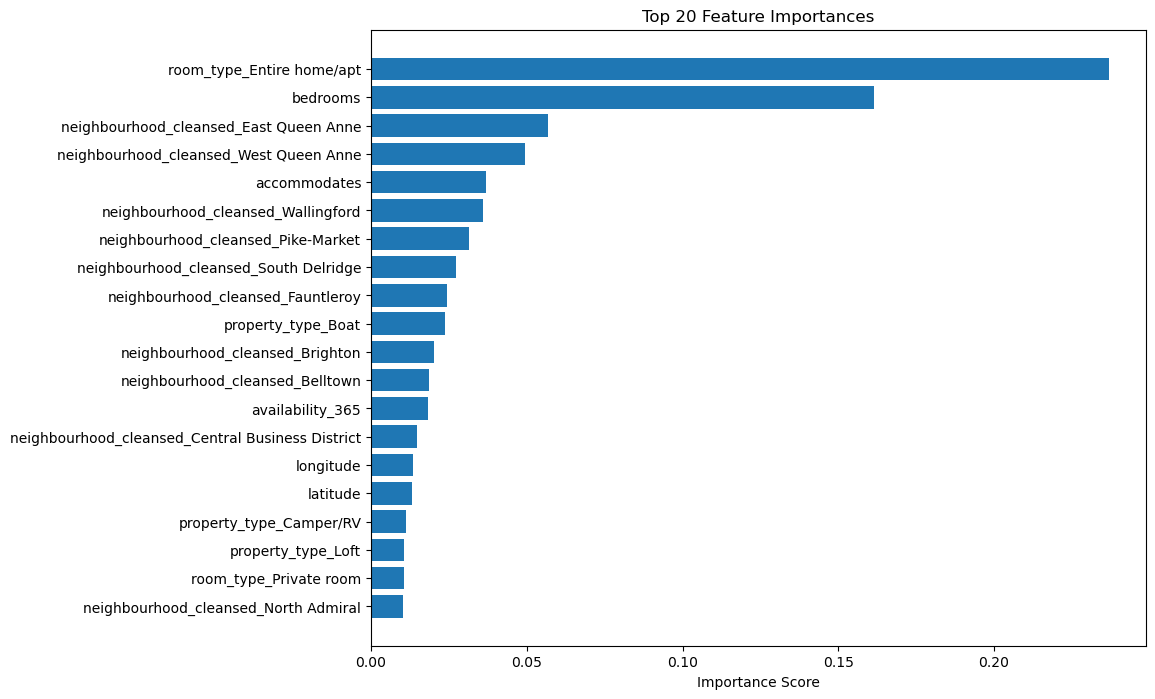

In [8]:
import matplotlib.pyplot as plt

# Extract the model from pipeline
xgb_model = model_pipeline.named_steps['model']

# Note: Because of the ColumnTransformer and OneHotEncoder, we need to reconstruct feature names.
# Get feature names from preprocessor
feature_names_num = numeric_features
feature_names_cat = model_pipeline.named_steps['preprocessing'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,8))
plt.barh(all_feature_names[sorted_idx][:20][::-1], importances[sorted_idx][:20][::-1])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.show()


A/B Test Results:
T-statistic: nan
P-value: nan
No significant difference found.


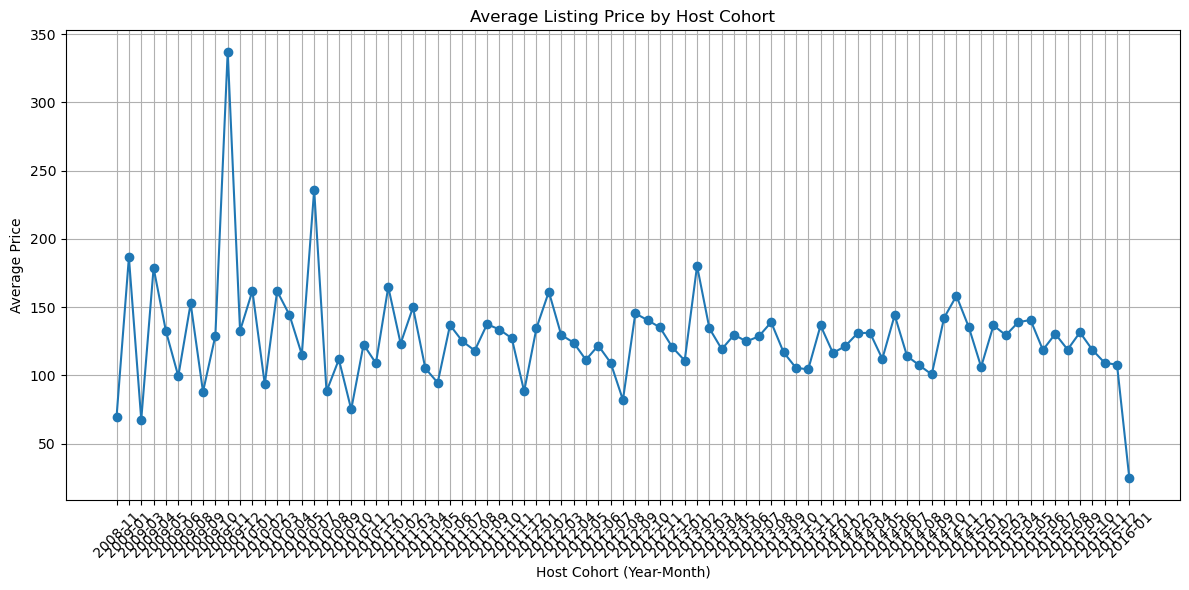

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Assume df_ab is a DataFrame with listings and metrics loaded from BigQuery
# Columns might include: listing_id, neighbourhood_cleansed, price_y, occupancy_rate, revenue

# A/B Testing Setup
# Let's say we choose two similar neighborhoods for a controlled experiment
neighborhood_treatment = "Neighborhood_A"
neighborhood_control = "Neighborhood_B"

df_ab = df.copy()  # Assuming df is the data queried from BigQuery
df_ab = df_ab[df_ab['availability_365'] > 50]  # Filter listings with some baseline availability

# Assign treatment and control groups
treatment_group = df_ab[df_ab['neighbourhood_cleansed'] == neighborhood_treatment].copy()
control_group = df_ab[df_ab['neighbourhood_cleansed'] == neighborhood_control].copy()

# Suppose we "simulate" a price increase in the treatment group
# (In practice, you'd implement the price change and wait a period of time to collect actual post-change data)
treatment_group['adjusted_price'] = treatment_group['price_y'] * 1.10  # 10% increase
control_group['adjusted_price'] = control_group['price_y']  # no change in control

# Simulate occupancy changes (In reality, you'd measure this after the experiment run)
np.random.seed(42)
treatment_group['post_treatment_occupancy'] = treatment_group['availability_365'] * np.random.uniform(0.5, 0.8, len(treatment_group))
control_group['post_treatment_occupancy'] = control_group['availability_365'] * np.random.uniform(0.5, 0.8, len(control_group))

# Compute revenue after adjustment (price * occupancy as a proxy)
treatment_group['post_treatment_revenue'] = treatment_group['adjusted_price'] * treatment_group['post_treatment_occupancy']
control_group['post_treatment_revenue'] = control_group['adjusted_price'] * control_group['post_treatment_occupancy']

# Statistical Test (t-test) to check if revenue differs significantly
t_stat, p_val = ttest_ind(treatment_group['post_treatment_revenue'].dropna(),
                          control_group['post_treatment_revenue'].dropna(),
                          equal_var=False)

print("A/B Test Results:")
print("T-statistic:", t_stat)
print("P-value:", p_val)
if p_val < 0.05:
    print("Significant difference between treatment and control groups at 95% confidence.")
else:
    print("No significant difference found.")

# Cohort Analysis Example
# Define cohort by host_since year
df_ab['host_since'] = pd.to_datetime(df_ab['host_since'], errors='coerce')
df_ab['host_cohort'] = df_ab['host_since'].dt.to_period('M')  # cohort by month-year of host signup

cohort_revenue = df_ab.groupby('host_cohort')['price_y'].mean().reset_index()
cohort_revenue['host_cohort'] = cohort_revenue['host_cohort'].astype(str)

plt.figure(figsize=(12,6))
plt.plot(cohort_revenue['host_cohort'], cohort_revenue['price_y'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Host Cohort (Year-Month)')
plt.ylabel('Average Price')
plt.title('Average Listing Price by Host Cohort')
plt.grid(True)
plt.tight_layout()
plt.show()

# From this analysis, you could incorporate occupancy or revenue metrics similarly.


Time Series Analysis


In [11]:
!pip install pmdarima

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Assume df_ts is a DataFrame with time series data loaded from BigQuery
# Columns might be: date (monthly), avg_price_per_night
# Ensure 'date' is a proper datetime column and set as index

df_ts = df.copy()  # Starting from a time-series aggregated df
# Example: Group by month and neighborhood to get average monthly price
df_ts['last_review'] = pd.to_datetime(df_ts['last_review'], errors='coerce')
df_monthly = df_ts.groupby(pd.Grouper(key='last_review', freq='M'))['price_y'].mean().reset_index()
df_monthly.set_index('last_review', inplace=True)
df_monthly = df_monthly.asfreq('M')  # Ensure monthly frequency

# Check for missing values and impute if necessary
df_monthly['price_y'].fillna(method='ffill', inplace=True)

# Plot historical trend
df_monthly['price_y'].plot(figsize=(12,6), title='Monthly Average Price Over Time')
plt.show()

# Auto-ARIMA to find best model order
model = auto_arima(df_monthly['price_y'], start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,  # 12 for monthly seasonality
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())

# Forecast the next 6 months
n_periods = 6
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(df_monthly.index[-1] + pd.offsets.MonthEnd(), periods=n_periods, freq='M')

# Convert to DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)
lower_conf, upper_conf = conf_int[:, 0], conf_int[:, 1]

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(df_monthly['price_y'], label='Historical')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, lower_conf, upper_conf, color='pink', alpha=0.3)
plt.title('Future Price Forecast')
plt.legend()
plt.show()

ImportError: cannot import name 'freq_to_period_freqstr' from 'pandas._libs.tslibs.dtypes' (/opt/anaconda3/lib/python3.12/site-packages/pandas/_libs/tslibs/dtypes.cpython-312-darwin.so)